### Data extraction "Joc de l'Habitatge"

In [1]:
import pymysql
import csv
import time
from datetime import datetime, date
import calendar
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import scipy.stats as stats


from collections import Counter

In [2]:
title_font = {'fontname': 'Helvetica', 'size': '14', 'color': 'black', 'weight': 'bold', 'verticalalignment': 'bottom'}  # Bottom vertical alignment for more space
axis_font = {'fontname': 'Helvetica', 'size': '12', 'weight': 'bold', 'color': 'black'}
ticks_font = {'fontname': 'Helvetica', 'size': '10',  'color': 'black', 'weight': 'bold'}

# Colors disseny
colors = ["#009fe3", "#20b200"]
tricolors_green = ["#8fd87f", "#20b200", "#105900"]

# Colors blanc/negre
colors = [ 'black', 'white']
bicolors = ['black', '#CCCCCC']
tricolors = ['#CCCCCC', '#888888', 'black']
tricolors_white = ['#FFFFFF', '#888888', 'black']

bicolors_black = ['black', 'black']
bicolors_white = ['white', 'white']
bicolors_grey = ['#CCCCCC', '#CCCCCC']



#### ToDo: Revise the control variables

In [3]:
def data_extraction():

    host = '127.0.0.1'
    db = pymysql.connect(user='bibliolab', passwd='bibliolab2019', host=host, db='bibliolab_fortpienc')

    with db:
        
        
        # Database game
        c_game = db.cursor()
        c_game.execute("SELECT GAME.id, GAME.status, GAME.experiment, GAME.control_intervention FROM game_partida GAME ")
        data_game = c_game.fetchall()

        games = []

        for g in data_game:
            
            if g[1] != 'NO_VALID': # Game status
            
                c_round = db.cursor()
                c_round.execute("SELECT ROUND.id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.bucket_final_ronda, ROUND.rented, ROUND.calculada, ROUND.user_id FROM game_ronda ROUND WHERE ROUND.partida_id = %d ORDER BY ROUND.num_ronda ASC " %(g[0]))
                data_round = c_round.fetchall()

                rounds = []

                for r in data_round:
                    if r[5] == 1: # if round is calculated
                        round_ = {'id': r[0],
                                 'num_round': r[1],
                                 'price_init': r[2],
                                 'price_fini': r[3],
                                 'is_rented': r[4],
                                 'user_id': r[6]
                                 }
                        rounds.append(round_)
                        
                game = {'id': g[0],
                        'status': g[1],
                        'experiment': g[2],
                        'control_intervention': g[3],
                        'rounds': rounds
                       }
                
                if game['status'] != 'TEST':
                    games.append(game)


        # Database user
        c_user = db.cursor()
        c_user.execute("SELECT USER.id, USER.is_robot, USER.consent, USER.socio_pr1, USER.socio_pr2, USER.socio_pr3, USER.socio_pr4, USER.socio_pr5, USER.socio_pr6, USER.socio_pr7, USER.frame_pr1, USER.frame_pr2, USER.frame_pr3, USER.frame_pr4, USER.frame_pr5, USER.frame_pr6, USER.verification_attempts, USER.status, USER.acabat, USER.bots, USER.endowment_initial, USER.endowment_current, USER.endowment_final, USER.expenses, USER.tickets, USER.house, USER.house_price, USER.partida_id, USER.comment, USER.enquesta_final_pr1, USER.enquesta_final_pr2, USER.enquesta_final_pr3, USER.enquesta_final_pr4, USER.enquesta_final_pr5, USER.enquesta_final_pr6 FROM game_user USER ")
        data_user = c_user.fetchall()


        # Collect user data
        participants = []

        for u in data_user:

            control = {
                'is_robot': u[1], # is a robot?
                'consent': u[2], # is consented?
                'status': u[17], # status
                'acabat': u[18], # acabat?
                'bots': u[19], # number of bots selection
                'verification_attempts': u[16], # verification questions attemps
                'comments': u[28] # empty ("") if its all ok
            }
    
            #ToDo: Revise the control
            if control['is_robot'] == 0 and control['consent'] == 1 and control['acabat'] == 1 and control['bots'] < 2 and control['comments']=='':

                # Round information
                c_user_round = db.cursor()
                c_user_round.execute("SELECT USER_ROUND.id, USER_ROUND.ha_seleccionat, USER_ROUND.seleccio, USER_ROUND.temps_seleccio, USER_ROUND.endowment_variation, USER_ROUND.ronda_id, USER_ROUND.user_id, ROUND.num_ronda, ROUND.bucket_inici_ronda, ROUND.user_id FROM game_userronda USER_ROUND INNER JOIN game_ronda ROUND ON ROUND.id = USER_ROUND.ronda_id WHERE USER_ROUND.user_id = %d ORDER BY USER_ROUND.ronda_id ASC " %(u[0]))
                data_user_round = c_user_round.fetchall() 

                rounds = []
                num_round_rented = None
                
                for ur in data_user_round:  
                    round_ = {'id': ur[0],
                              'num_round': ur[7],
                              'is_selected': ur[1], # round is selected?
                              'selection': ur[2], # round selection
                              'time_selection': ur[3], # time selection
                              'price': ur[8],
                             }
                    rounds.append(round_)
                    
                    if ur[9] == u[0] and ur[2]:
                        num_round_rented = ur[7]
                    

                socio = {'socio_pr1': u[3], # q: Identitat de gènere r1: Home; r2: Dona; r3: No binària; r4: No vull contestar;
                         'socio_pr2': u[4], # q: Rang d'edat r1: Menor de 14; r2: 14 - 17; r3: 18 - 24; r4: 25 - 34; r5: 35 - 44; r6: 45 - 54; r7: 55 - 64; r8: Major de 65;
                         'socio_pr3': u[5], # q: Codi Postal
                         'socio_pr4': u[6], # q: Nivell d'estudis finalitzats r1: Cap; r2: Obligatoris; r3: Secundaris generals; r4: Secundaris professionals; r5: Universitaris; r6: Altres;
                         'socio_pr5': u[7], # q: Amb qui vius? r1: Sol; r2: Llar sense persones a càrrec; r3: Llars amb persones a càrrec; r4: Més persones que no són parella;
                         'socio_pr6': u[8], # q: Règim de tinença de la teva llar r1: En propietat; r2: En propietat pendent de pagament (hipoteca); r3: En lloguer o relloguer a preu de mercat; r4: En lloguer o relloguer a preu inferior al de mercat ; r5: En cessió gratuïta; r6: Habitació de lloguer; r7: Ocupació; r8: Altres; 
                         'socio_pr7': u[9], # q: Ets propietari d’algun habitatge que està en règim de lloguer? r1: Sí; r2: No; r3: No vull contestar;
                        }

                frame = {'frame_pr1': u[10], # q: En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquest experiment sobre el tema de l'habitatge? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr2': u[11], # q: En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? r1: Poc; r2: Normal; r3: Molt
                         'frame_pr3': u[12], # q: En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu? r1: Poc; r2: Normal; r3: Molt;
                         'frame_pr4': u[13], # q: Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}? r1: 300 euros; r2: 400 euros; r3: 500 euros; r4: 600 euros; r5: 700 euros; r6: 800 euros; r7: 900 euros; r8: 1000 euros;
                         'frame_pr5': u[14], # q: Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                         'frame_pr6': u[15], # q: Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge? r1: <25%; r2: 25-34%; r3: 35-44%; r4: 45-54%; r5: 55-64%; r6: 65-74%; r7: >74%;
                        }
                
                final = {'final_pr1': u[29], # q: En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? 
                         'final_pr2': u[30], # q: En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat?
                         'final_pr3': u[31], # q: En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? 
                         'final_pr4': u[32], # q: En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 
                         'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
                         'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
                }
                

                # Participant Dictionary
                game = [g for g in games if g['id'] == u[27]][0]
                
                participant = {'id': u[0],
                               'game': game,
                               'intervention': game['control_intervention'],
                               'control': control,
                               'socio': socio,
                               'frame': frame,
                               'final': final,
                               'rounds': rounds,
                               'endowment_initial': u[20], 
                               'endowment_current': u[21],
                               'endowment_final': u[22],
                               'expenses': u[23],
                               'tickets': u[24], 
                               'house': u[25], 
                               'house_price': u[26], 
                               'round_rented': num_round_rented
                              }
                
                participants.append(participant)
        
        
    return games, participants
    

In [48]:
games, participants = data_extraction()

df_games = pd.DataFrame(games)
df_participants = pd.DataFrame(participants)

participants_TS = [p for p in participants if p['game']['experiment'] == 'Test']
participants_FP = [p for p in participants if p['game']['experiment'] == 'FortPienc']
participants_GR = [p for p in participants if p['game']['experiment'] == 'Granollers']
participants_OM = [p for p in participants if p['game']['experiment'] == 'Olesa']

df_participants_TS = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Test'])
df_participants_FP = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'FortPienc'])
df_participants_GR = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Granollers'])
df_participants_OM = pd.DataFrame([p for p in participants if p['game']['experiment'] == 'Olesa'])

df_games_TS = df_games.loc[df_games['experiment'] == 'Test']
df_games_FP = df_games.loc[df_games['experiment'] == 'FortPienc']
df_games_GR = df_games.loc[df_games['experiment'] == 'Granollers']
df_games_OM = df_games.loc[df_games['experiment'] == 'Olesa de Montserrat']

print '----------------------'
print 'Games and Participants'
print 'TS: ' + str(len(df_games_TS)) + '(' + str(6*len(df_games_TS)) + ' p.)' 
print 'FP: ' + str(len(df_games_FP)) + '(' + str(6*len(df_games_FP)) + ' p.)' 
print 'GR: ' + str(len(df_games_GR)) + '(' + str(6*len(df_games_GR)) + ' p.)' 
print 'OM: ' + str(len(df_games_OM)) + '(' + str(6*len(df_games_OM)) + ' p.)' 

print '------------------'
print 'Valid Participants'
print 'TS: ' + str(len(df_participants_TS))
print 'FP: ' + str(len(df_participants_FP))
print 'GR: ' + str(len(df_participants_GR))
print 'TS: ' + str(len(df_participants_OM))


----------------------
Games and Participants
TS: 0(0 p.)
FP: 15(90 p.)
GR: 0(0 p.)
OM: 0(0 p.)
------------------
Valid Participants
TS: 0
FP: 75
GR: 0
TS: 0


### Sociodemographics

In [5]:
text_dataset = 'socio_FP' 
participants = participants_FP
df_participants_socio = pd.DataFrame(list(df_participants_FP['socio']))


#### Identitat de genere

|  |socio_pr1|
|----------|
|r1| Home | 
|r2| Dona | 
|r3| No binària | 
|r4| No vull contestar |

#### Rang d'edat

|  |socio_pr2| 
|------------|
|r1| Menor de 14 | 
|r2| 14 - 17 | 
|r3| 18 - 24 | 
|r4| 25 - 34 | 
|r5| 35 - 44 | 
|r6| 45 - 54 | 
|r7| 55 - 64 | 
|r8| Major de 65|

-----
Total Participants: 75
Total Women: 46 - 0.61
Total Men:  29 - 0.39
Total Other:  0 - 0.00
-----


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


,label,value,per
0,<14,0,0.000000
1,14-17,0,0.000000
2,18-24,13,0.173333
3,25-34,7,0.093333
4,35-44,25,0.333333
5,45-54,20,0.266667
6,55-64,7,0.093333
7,>64,3,0.040000


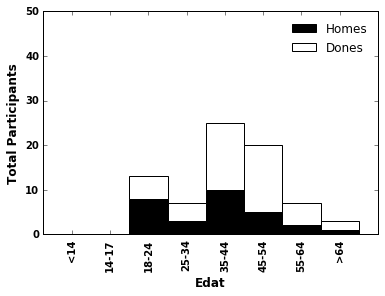

In [6]:
socio_pr2 = [p['socio']['socio_pr2'] for p in participants]

socio_pr2_women = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'W']
socio_pr2_men = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] == 'M']
socio_pr2_none = [p['socio']['socio_pr2'] for p in participants if p['socio']['socio_pr1'] != 'W' and p['socio']['socio_pr1'] != 'M']

print ('-----')
print ('Total Participants: %d' %(len(participants)))
print ('Total Women: %d - %.2f' %(len(socio_pr2_women), float(len(socio_pr2_women))/float(len(participants))))
print ('Total Men:  %d - %.2f' %(len(socio_pr2_men), float(len(socio_pr2_men))/float(len(participants))))
print ('Total Other:  %d - %.2f' %(len(socio_pr2_none), float(len(socio_pr2_none))/float(len(participants))))
print ('-----')


df_ages = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2.count('r1'), socio_pr2.count('r2'), socio_pr2.count('r3'), 
                                  socio_pr2.count('r4'), socio_pr2.count('r5'), socio_pr2.count('r6'), 
                                  socio_pr2.count('r7'), socio_pr2.count('r8')]})

df_ages['per'] = df_ages['value']/len(participants)

df_women = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'], 
                         'value':[socio_pr2_women.count('r1'), socio_pr2_women.count('r2'), socio_pr2_women.count('r3'), 
                                  socio_pr2_women.count('r4'), socio_pr2_women.count('r5'), socio_pr2_women.count('r6'), 
                                  socio_pr2_women.count('r7'), socio_pr2_women.count('r8')]})

df_men = pd.DataFrame({'label':['<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'],
                       'value':[socio_pr2_men.count('r1'), socio_pr2_men.count('r2'), socio_pr2_men.count('r3'), 
                            socio_pr2_men.count('r4'), socio_pr2_men.count('r5'), socio_pr2_men.count('r6'), 
                            socio_pr2_men.count('r7'), socio_pr2_men.count('r8')]})

max_y = 10

df_gender = pd.DataFrame()
df_gender['men'] = df_men['value']
df_gender['women'] = df_women['value']

plt.clf()
fig, ax = plt.subplots()
ax = df_gender[['men', 'women']].plot.bar(stacked=True, width=1, position=0.5, ax=ax, alpha=1, color=[colors[0], colors[1]])
max_y = 50
plt.xticks(np.arange(0,9),('<14', '14-17', '18-24', '25-34', '35-44', '45-54', '55-64', '>64'), **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Edat', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.legend(['Homes','Dones'], fancybox=True, framealpha=0)
plt.ylim(0,max_y)

plt.savefig('figures/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
df_ages

#### On vius? (CP)

| |socio_pr3|
|-----------|
|**Granollers**|08401 / 08402 / 08403 |
|**Olesa de Montserrat**| 08640 |
|**Fort Pienc**| 08013 |

#### Fort Pienc

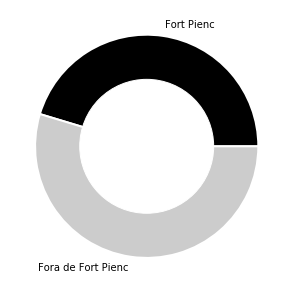

,label,value,perc
0,Fort Pienc,34,0.453333
1,Fora de\nFort Pienc,41,0.546667


In [50]:
socio_pr3 = [p['socio']['socio_pr3'] for p in participants]

################
## Fort Pienc ##
################
fortpienc = socio_pr3.count('08013') + socio_pr3.count('8013')
fora_fortpienc = len(socio_pr3) - fortpienc

df_fortpienc = pd.DataFrame({'label':['Fort Pienc', 'Fora de\nFort Pienc'], 
                              'value':[fortpienc, fora_fortpienc]})

df_fortpienc['perc'] =  df_fortpienc['value']/len(socio_pr3)

labels = ['Fort Pienc', 'Fora de Fort Pienc']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie([fortpienc, fora_fortpienc], labels=labels, colors=bicolors,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/02_fortpienc_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

df_fortpienc


#### Nivell d'estudis finalitzats

|  | socio_pr4 |
|------------------------------|
|r1|Cap|
|r2|Obligatoris (primària, EGB, ESO)|
|r3|Secundaris generals (batxillerat, PREU, BUP, COU)|
|r4|Secundaris professionals (comerç, FP1, FP2, mòduls, grau mitja/superior)|
|r5|Universitaris (grau, diplomatura, llicenciatura, màster, postgrau, doctorat)|
|r6|Altres|

/usr/local/lib/python2.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


r1         NaN
r2    0.080000
r3    0.213333
r4    0.120000
r5    0.586667
r6         NaN
Name: socio_pr4, dtype: float64

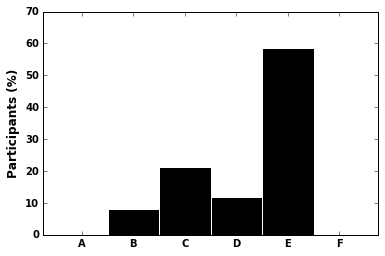

In [8]:

plt.clf()

plt_studies = df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
#plt_studies.set_xticklabels(['Cap', 'Obligatoris', 'Secundaris\nGenerals', 'Secundaris\nProfessionals', 'Universitaris', 'Altres'])
plt_studies.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

plt.savefig('figures/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4', 'r5', 'r6']]


#### Amb qui vius?


|| socio_pr5 |
|------------|
|r1|Sol|
|r2|Llar sense persones a càrrec|
|r3|Llar amb persones a càrrec|
|r4|Més persones que no són parella|

r1    0.120000
r2    0.160000
r3    0.586667
r4    0.133333
Name: socio_pr5, dtype: float64

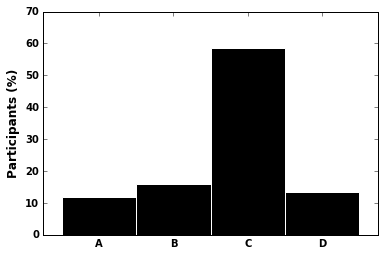

In [9]:
plt_who_lives = df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")

# plt_studies.get_legend().remove()
#plt_who_lives.set_xticklabels(['Sol', 'Llar sense persones\na carrec', 'Llar amb persones\na carrec', 'Mes persones que\nno son parella'])
plt_who_lives.set_xticklabels(['A', 'B', 'C', 'D'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 15, 
#         'A: Sol\nB: Llar sense persones a carrec\nC: Llar amb persones a carrec\nD: Mes persones que no son parella',
#         **ticks_font)
plt.savefig('figures/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4']]


#### Règim de tinença de la teva llar
| |socio_pr6|
|----------|
|r1|En propietat|
|r2|En propietat pendent de pagament (hipoteca)|
|r3|En lloguer o relloguer a preu de mercat|
|r4|En lloguer o relloguer a preu inferior al de mercat|
|r5|En cessió gratuïta|
|r6|Habitació de lloguer|
|r7|Ocupació|
|r8|Altres|

r1    0.320000
r2    0.186667
r3    0.253333
r4    0.133333
r5    0.026667
r6    0.040000
r7         NaN
r8    0.040000
Name: socio_pr6, dtype: float64

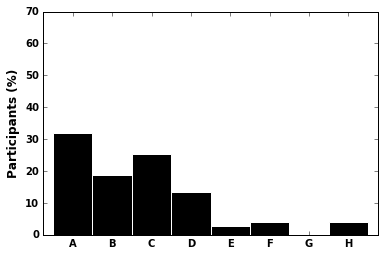

In [10]:
plt.clf()
plt_home_tenancy = df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
# plt_home_tenancy.set_xticklabels(['En propietat', 'En propietat pendent de pagament (hipoteca)', 'En lloguer o relloguer a preu de mercat', 'En lloguer o relloguer a preu inferior al de mercat', 'En cessio gratuita', 'Habitacio de lloguer', 'Ocupacio', 'Altres'])
plt_home_tenancy.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])

max_y = 0.7
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], ['0',10,20,30,40,50,60,70], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.ylim(0,max_y)

#plt.text(0, max_y - 25, 
#         'A: En propietat\nB: En propietat pendent de pagament (hipoteca)\nC: En lloguer o relloguer a preu de mercat\nD: En lloguer o relloguer a preu inferior al de mercat\nE: En cessio gratuita\nF: Habitacio de lloguer\nG: Ocupacio\nH: Altres',
#         **ticks_font)
plt.savefig('figures/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_socio['socio_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]


#### Ets propietari d’algun habitatge que està en règim de lloguer?
||socio_pr7|
|----------|
|r1|Sí|
|r2|No|
|r3|No vull contestar|

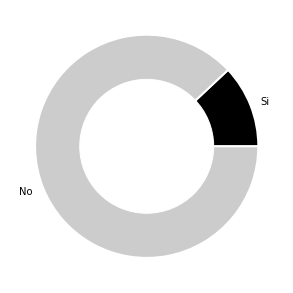

r1    0.12
r2    0.88
r3     NaN
Name: socio_pr7, dtype: float64

In [51]:
plt.clf()

freq_owner = df_participants_socio['socio_pr7'].value_counts(normalize=True)[['r1', 'r2', 'r3']]

labels = ['Si', 'No', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_owner, labels=labels, colors=bicolors,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/07_'+text_dataset+'.png', bbox_inches='tight', dpi=300)
plt.show()

freq_owner

### Frame

In [12]:
text_dataset = 'frame_FP' 
df_participants_frame = pd.DataFrame(list(df_participants_FP['frame']))
df_participants_frame.tail()

mapping_pr4 = {'r1': 300, 'r2': 400, 'r3': 500, 'r4': 600, 'r5': 700, 'r6': 800, 'r7': 900, 'r8': 1000, 'rx': None}
df_participants_frame_numeric = df_participants_frame.replace({'frame_pr4': mapping_pr4})


#### Codiseny

**pr1:** En quina mesura comparteixes la inquietud triada pels veïns que han participat en el co-disseny d'aquesta recerca sobre el tema de l'habitatge?



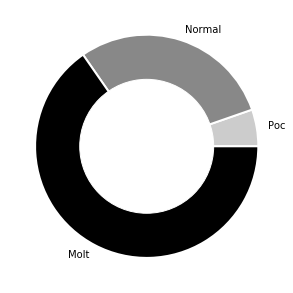

r1    0.053333
r2    0.293333
r3    0.653333
Name: frame_pr1, dtype: float64

In [13]:
pr1_counts = df_participants_frame['frame_pr1'].value_counts(normalize=True)[['r1', 'r2', 'r3']]
pr1_counts=pr1_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

patches, texts = plt.pie(pr1_counts, labels=labels, colors=tricolors, 
                                    wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr1_counts

#### Polítiques Públiques

**pr2:** En quina mesura estàs d'acord amb una regulació que limiti el preu del lloguer? **pr3:** En quina mesura estàs d'acord amb una regulació fiscal que permeti la concessió d'ajuts per facilitar l'accés a l'habitatge i mantenir el preu?

||frame_pr2|frame_pr3|
|---------------------|
|r1|Poc|Poc|
|r2|Normal|Normal|
|r3|Molt|Molt|


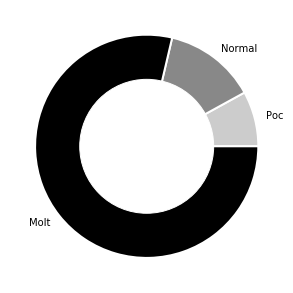

r1    0.080000
r2    0.133333
r3    0.786667
Name: frame_pr2, dtype: float64

In [14]:
pr2_counts = df_participants_frame['frame_pr2'].value_counts(normalize=True)[['r1', 'r2', 'r3']]

pr2_counts=pr2_counts.fillna(0)


fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

plt.pie(pr2_counts, labels=labels, 
        colors=tricolors, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio que limita el preu', **title_font)
plt.savefig('figures/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

pr2_counts

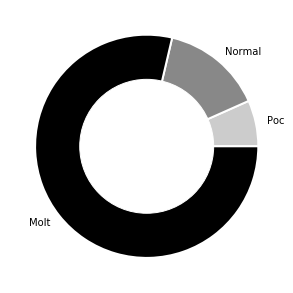

r1    0.066667
r2    0.146667
r3    0.786667
Name: frame_pr3, dtype: float64

In [15]:
pr3_counts = df_participants_frame['frame_pr3'].value_counts(normalize=True)[['r1', 'r2', 'r3']]
pr3_counts=pr3_counts.fillna(0)

labels = ['Poc', 'Normal', 'Molt']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white')

plt.pie(pr3_counts, labels=labels, 
        colors=tricolors, 
        wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
#plt.title('Regulacio fiscal per ajuts', **title_font)
plt.savefig('figures/03_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

pr3_counts

**pr4:** Quin creus que és el preu mig del lloguer d’una casa de 70m2 en bones condicions a {municipi}?

r1    0.026667
r2    0.013333
r3    0.053333
r4    0.026667
r5    0.120000
r6    0.133333
r7    0.280000
r8    0.346667
Name: frame_pr4, dtype: float64

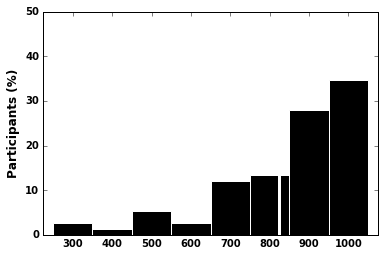

In [16]:
df_participants_frame['frame_pr4']

plt.clf()
plt_rent = df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']].plot(kind='bar', rot=0, width=1, color=colors[0], edgecolor = "white")
plt_rent.set_xticklabels(['300', '400', '500', '600', '700', '800', '900', '1000'])

max_y = 0.5
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
#plt.title('Regim de tinenca de la teva llar', **title_font)
plt.vlines(5.229, 0, 1000, colors=colors[1], linewidth=3)
plt.ylim(0,max_y)
plt.savefig('figures/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_frame['frame_pr4'].value_counts(normalize=True)[['r1', 'r2', 'r3', 'r4','r5', 'r6', 'r7', 'r8']]
#df_participants_frame_numeric['frame_pr4'].describe()


### Despeses Habitatge

**pr5:** Quin percentatge dels teus ingressos mensuals nets dediques a despeses associades a l’accés a l’habitatge?
**pr6:** Quin percentatge dels teus ingressos mensuals nets consideres just dedicar a despeses associades a l’accés a l’habitatge?

||frame_pr5|frame_pr6|
|---------------------|
|r1|<25%|<25%|
|r2|25-34%|25-34%|
|r3|35-44%|35-44%|
|r4|45-54%|45-54%|
|r5|55-64%|55-64%|
|r6|65-74%|65-74%|
|r7|>74%|>74%|


#### Tots el participants


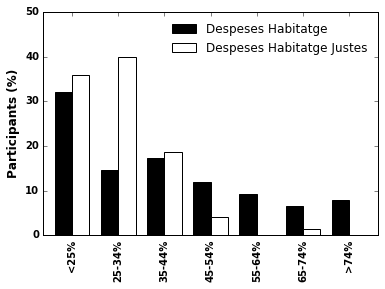

In [17]:
pr5_counts = df_participants_frame['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts = df_participants_frame['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts, 'pr6': pr6_counts}, index=index)

plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")
#plt_expenses = df_expenses['pr5'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")
#plt_expenses = df_expenses['pr6'].plot(kind='bar', rot=90, width=1, color=colors[0], edgecolor = "white")

max_y = 0.5
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5], ['0',10,20,30,40,50], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

plt.savefig('figures/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)



#### Participants que són llogueters


En regim de lloguer a qualsevol preu


,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6,socio_pr1,socio_pr2,socio_pr3,socio_pr4,socio_pr5,socio_pr6,socio_pr7
count,29,29,29,29,29,29,29,29,29,29,29,29,29
unique,2,2,3,4,7,3,2,5,12,4,4,2,2
top,r3,r3,r3,r8,r3,r2,W,r5,08013,r5,r3,r3,r2
freq,25,28,27,14,10,16,16,12,13,19,17,19,27


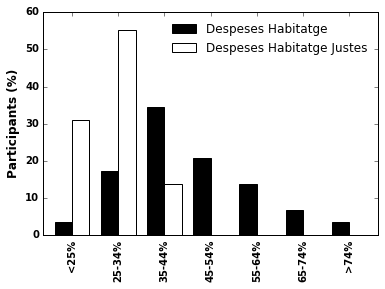

In [18]:
df_participants_socio_frame = pd.concat([df_participants_frame,df_participants_socio], axis=1, join='inner')

print 'En regim de lloguer a qualsevol preu'
df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3') | (df_participants_socio_frame['socio_pr6']=='r4')]

#print 'En regim de lloguer a preu de mercat'
#df_participants_llogaters = df_participants_socio_frame[(df_participants_socio_frame['socio_pr6']=='r3')]

pr5_counts_llogaters = df_participants_llogaters['frame_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]
pr6_counts_llogaters = df_participants_llogaters['frame_pr6'].value_counts(normalize=True)[['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']]

index = ['r1', 'r2', 'r3','r4', 'r5', 'r6','r7']
df_expenses = pd.DataFrame({'pr5': pr5_counts_llogaters, 'pr6': pr6_counts_llogaters}, index=index)

plt_expenses = df_expenses.plot(kind='bar', rot=90, width=0.75, color=colors, edgecolor = "black")

max_y = 0.60
# plt_expenses.get_legend().remove()
plt_expenses.set_xticklabels(['<25%', '25-34%', '35-44%', '45-54%', '55-64%', '65-74%', '>74%'])
# plt_expenses.set_xticklabels(['A', 'B', 'C','D', 'E', 'F', 'G'])
plt.xticks(**ticks_font)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6], ['0',10,20,30,40,50,60], **ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Participants (%)', **axis_font)
plt.title('', **title_font)
plt.ylim(0,max_y)
plt.legend(['Despeses Habitatge', 'Despeses Habitatge Justes'], fancybox=True, framealpha=0)

plt.savefig('figures/05_llogaters_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#pr5_counts_llogaters
#pr6_counts_llogaters
df_participants_llogaters.describe()

### Preguntes finals

In [19]:
text_dataset = 'final_FP' 
df_participants_final = pd.DataFrame(list(df_participants_FP['final']))

#'final_pr5': u[33], # q: Coneixes iniciatives d’habitatge cooperatiu?
#'final_pr6': u[34], # q: En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    
    

**pr1:** En quina mesura creus que ha d’haver-hi un control públic de l’habitatge? **pr2:** En quina mesura estàs d’acord amb la necessitat de tenir un sistema que garanteixi la consideració de l’habitatge com un bé de primera necessitat? **pr3:** En quina mesura creus que la presència de pisos buits afecta la situació de l'habitatge al municipi? **pr4:** En quina mesura estàs d’acord amb la necessitat de prioritzar el dret a l’habitatge per a col·lectius vulnerables? 



,final_pr1,final_pr2,final_pr3,final_pr4,final_pr6
count,75.000000,75.000000,75.000000,75.00000,63.000000
mean,6.053333,6.613333,6.186667,6.00000,5.222222
std,1.487728,1.161236,1.291274,1.46121,1.507449
min,0.000000,0.000000,1.000000,0.00000,0.000000
25%,5.000000,7.000000,6.000000,5.00000,4.500000
50%,7.000000,7.000000,7.000000,7.00000,5.000000
75%,7.000000,7.000000,7.000000,7.00000,6.500000
max,7.000000,7.000000,7.000000,7.00000,7.000000


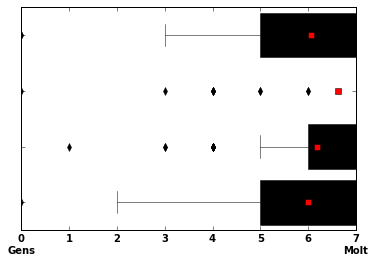

In [20]:
plt.clf()
mapping = {'r1': 0, 'r2': 1, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 5, 'r7': 6, 'r8': 7, 'rx': None}
df_participants_final_numeric = df_participants_final.replace({'final_pr1': mapping, 'final_pr2': mapping, 'final_pr3': mapping, 'final_pr4': mapping, 'final_pr6': mapping})
ax = sns.boxplot(data=df_participants_final_numeric[['final_pr1','final_pr2','final_pr3','final_pr4']], 
            orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])

ax.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
#ax.set_yticklabels(['Q1', 'Q2', 'Q3', 'Q4'], **ticks_font)
ax.set_yticklabels(['', '', '', ''], **ticks_font)
plt.savefig('figures/01_04_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

#df_participants_final_numeric['final_pr1'].describe()
#df_participants_final_numeric['final_pr2'].describe()
#df_participants_final_numeric['final_pr3'].describe()
#df_participants_final_numeric['final_pr4'].describe()
df_participants_final_numeric.describe()




**pr5** Coneixes iniciatives d’habitatge cooperatiu? **pr6** En quina mesura creus que les iniciatives d’habitatge cooperatiu poden millorar l’eficiència del model d’habitatge actual? (opcional)
    

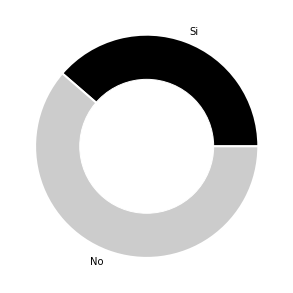

,final_pr6
count,63.000000
mean,5.222222
std,1.507449
min,0.000000
25%,4.500000
50%,5.000000
75%,6.500000
max,7.000000


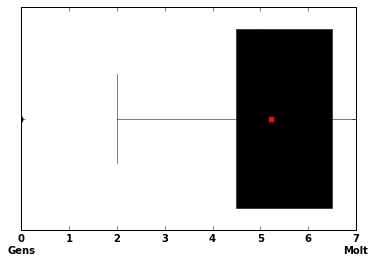

In [21]:
plt.clf()

freq_cooperative = df_participants_final['final_pr5'].value_counts(normalize=True)[['r1', 'r2', 'r3']]

labels = ['Si', 'No', '']

fig = plt.figure(figsize=(5,5))
circle = plt.Circle((0,0),0.6,color='white',alpha=1)

patches, texts = plt.pie(freq_cooperative, labels=labels, colors=bicolors,
                         wedgeprops={'linewidth': 2, 'linestyle': 'solid', 'antialiased': True, 'edgecolor': 'white'})

p=plt.gcf()
p.gca().add_artist(circle)
plt.savefig('figures/05_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()


plt.clf()

ax = sns.boxplot(data=df_participants_final_numeric[['final_pr6']], orient = 'h', linewidth=0.5, showmeans=True, color=colors[0])
ax.set_xticklabels(['0\nGens', '1', '2', '3', '4', '5', '6', '7\nMolt'], **ticks_font)
#ax.set_yticklabels(['Q6'], **ticks_font)
ax.set_yticklabels([''], **ticks_font)
plt.savefig('figures/06_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_participants_final_numeric[['final_pr6']].describe()
                              
                              

### Preu dels lloguer

In [22]:
text_dataset = 'economy_FP' 
rent_FP = 1943
df_participants_economy = df_participants_FP[['id', 'intervention', 'house', 'house_price', 'round_rented', 'endowment_final']].copy()
df_participants_economy['decication'] = df_participants_economy['house_price']/rent_FP
df_participants_economy

,id,intervention,house,house_price,round_rented,endowment_final,decication
0,32,NONE,1,916.650000,2.0,1026.350000,0.471770
1,33,NONE,1,780.033171,11.0,1162.966829,0.401458
2,34,NONE,1,873.000000,1.0,1070.000000,0.449305
3,35,NONE,1,819.034830,12.0,1123.965170,0.421531
4,36,NONE,1,744.750611,8.0,1198.249389,0.383299
5,37,NONE,1,742.888735,10.0,1200.111265,0.382341
6,38,BOTH,1,864.302683,9.0,1078.697317,0.444829
7,39,BOTH,1,819.034830,12.0,1123.965170,0.421531
8,40,BOTH,1,866.468855,7.0,1076.531145,0.445944
9,41,BOTH,1,868.640456,5.0,1074.359544,0.447061


#### Preu mitja que els participants han pagat pel lloguer

In [23]:
df_participants_economy[df_participants_economy['house'] == 1]['house_price'].describe()


count      74.000000
mean      870.225245
std        67.529778
min       742.888735
25%       819.548010
50%       873.000000
75%       916.650000
max      1061.136956
Name: house_price, dtype: float64

#### Preu mitja que els participants han pagat pel lloguer segons tractament

In [24]:
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['house_price'].describe()


NONE


count      35.000000
mean      860.935609
std        76.308893
min       742.888735
25%       803.458665
50%       866.468855
75%       914.361240
max      1061.136956
Name: house_price, dtype: float64

In [25]:
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['house_price'].describe()



BOTH


count     39.000000
mean     878.562099
std       58.306166
min      742.888735
25%      866.468855
50%      873.000000
75%      916.650000
max      962.482500
Name: house_price, dtype: float64

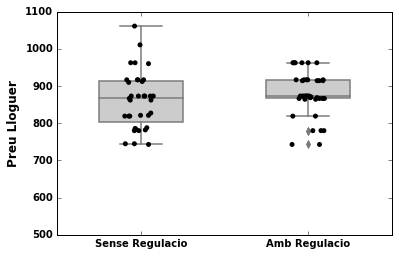

In [26]:
bplot=sns.stripplot(x='intervention', # vertical
                    y='house_price',
                    orient = 'v',
                    data=df_participants_economy, 
                    jitter=True, 
                    marker='o', 
                    palette=bicolors_black, 
                    edgecolor=bicolors_black, 
                    facecolors="none")


bplot=sns.boxplot(x='intervention', # vertical
                  y='house_price',
                  orient = 'v', 
                  data=df_participants_economy, 
                  width=.5, 
                  palette=bicolors_grey, 
                  linewidth=1.5,
                  #showmeans=True
                 )

min_y = 500
max_y = 1100
plt.xticks([0,1], ['Sense Regulacio', 'Amb Regulacio'],**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.ylim(min_y, max_y)

plt.savefig('figures/01_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


#### Dedicacio a les despeses de habitatge

Mitjana despeses habitatge


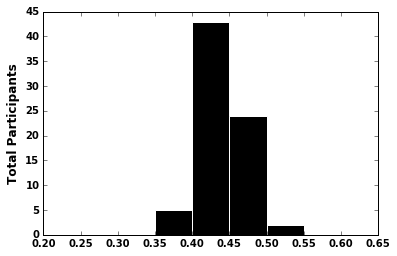

In [27]:
print 'Mitjana despeses habitatge'
df_participants_economy['decication'].describe()

fig, ax = plt.subplots()
df_participants_economy['decication'].hist(bins=[0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65], color=colors[0], edgecolor = "white")
min_y = 0
max_y = 50
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Total Participants', **axis_font)
plt.grid(False)

plt.savefig('figures/01_dedication_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


#plt.title('', **title_font)
#plt.ylim(min_y, max_y)


### Evolució del mercat

#### Mesos que tarden en llogar un habitatge

In [28]:
text_treatment = 'ALL'
df_participants_economy[(df_participants_economy['house'] == 1)]['round_rented'].describe()


count    74.000000
mean      5.608108
std       3.881172
min       1.000000
25%       2.000000
50%       5.000000
75%       9.000000
max      12.000000
Name: round_rented, dtype: float64

In [29]:
text_treatment = 'NONE'
print 'NONE'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'NONE')]['round_rented'].describe()


NONE


count    35.000000
mean      5.971429
std       3.951811
min       1.000000
25%       2.000000
50%       5.000000
75%      10.000000
max      12.000000
Name: round_rented, dtype: float64

In [30]:
text_treatment = 'BOTH'
print 'BOTH'
df_participants_economy[(df_participants_economy['house'] == 1) & (df_participants_economy['intervention'] == 'BOTH')]['round_rented'].describe()



BOTH


count    39.000000
mean      5.282051
std       3.838508
min       1.000000
25%       2.000000
50%       4.000000
75%       8.500000
max      12.000000
Name: round_rented, dtype: float64

#### Impacte de les polítiques de habitatge

#### Preus acceptats i no acceptats

In [31]:
num_round = []
selections = []
prices = []
intervention = []

for index, d in enumerate(df_participants_FP['rounds']):
    for r in d:
        if r['is_selected'] == 1:
            num_round.append(r['num_round'])
            selections.append(r['selection'])
            prices.append(r['price'])
            intervention.append(df_participants_FP.iloc[index]['intervention'])
            
df_prices = pd.DataFrame({'num_round': num_round, 'selections': selections, 'prices': prices, 'intervention': intervention})



#### Acceptació del preu de entrada



In [32]:
acceptacio = df_prices[df_prices['num_round']==1]['selections'].value_counts(normalize=True)
print 'El %.2f no va aceptar el preu proposat' %(acceptacio[0]*100)
print 'El %.2f va aceptar el preu proposat' %(acceptacio[1]*100)


El 52.70 no va aceptar el preu proposat
El 47.30 va aceptar el preu proposat


#### Preu mitjà que els participants han estat disposats a pagar pel lloguer


In [33]:
print 'Preus acceptats'
df_prices[(df_prices['selections'] == 1)]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()


Preus acceptats


count     129.000000
mean      877.588008
std        58.396983
min       742.888735
25%       866.468855
50%       873.000000
75%       916.650000
max      1061.136956
Name: prices, dtype: float64

In [34]:
print 'Preus acceptats tractament sense intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament sense intervencio


count      55.000000
mean      865.294378
std        67.822690
min       742.888735
25%       819.034830
50%       873.000000
75%       913.215427
max      1061.136956
Name: prices, dtype: float64

In [35]:
print 'Preus acceptats tractament amb intervencio'
df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].describe()
#df_prices[(df_prices['selections'] == 1)]['prices'].hist()

Preus acceptats tractament amb intervencio


count     74.000000
mean     886.725166
std       48.768481
min      742.888735
25%      868.640456
50%      873.000000
75%      916.650000
max      962.482500
Name: prices, dtype: float64

In [36]:
print 'Preus no acceptats'
df_prices[(df_prices['selections'] == 0)]['prices'].describe()
#df_prices[(df_prices['selections'] == 0)]['prices'].hist()


Preus no acceptats


count     296.000000
mean      889.279141
std        62.555684
min       742.888735
25%       864.302683
50%       907.517817
75%       916.650000
max      1114.193804
Name: prices, dtype: float64

#### Histograma dels preus acceptats

,price,1,0,perc_1,perc_0
0,745.0,6.0,9.0,0.400000,0.600000
1,783.0,11.0,23.0,0.323529,0.676471
2,823.0,8.0,34.0,0.190476,0.809524
3,867.0,58.0,78.0,0.426471,0.573529
4,911.0,29.0,89.0,0.245763,0.754237
5,958.0,15.0,53.0,0.220588,0.779412
6,1008.0,1.0,7.0,0.125000,0.875000
7,1060.0,1.0,2.0,0.333333,0.666667
8,1114.0,0.0,1.0,0.000000,1.000000


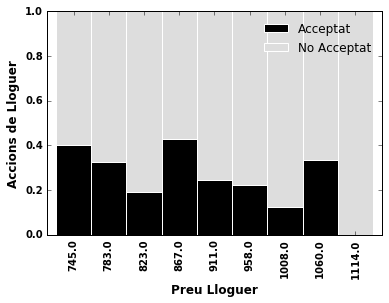

In [37]:
## Binned All Games

df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1)]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0)]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index

df_prices_count['price'].iloc[18:20]

prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:9])), 
           np.round(np.mean(df_prices_count['price'].iloc[9:16])), 
           np.round(np.mean(df_prices_count['price'].iloc[16:23])), 
           np.round(np.mean(df_prices_count['price'].iloc[23:29])), 
           np.round(np.mean(df_prices_count['price'].iloc[29:34])), 
           np.round(np.mean(df_prices_count['price'].iloc[34:37])), 
           np.round(np.mean(df_prices_count['price'].iloc[37:39])), 
           np.round(np.mean(df_prices_count['price'].iloc[39]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['1'].iloc[3:9])), 
         np.round(np.sum(df_prices_count['1'].iloc[9:16])), 
         np.round(np.sum(df_prices_count['1'].iloc[16:23])), 
         np.round(np.sum(df_prices_count['1'].iloc[23:29])), 
         np.round(np.sum(df_prices_count['1'].iloc[29:34])), 
         np.round(np.sum(df_prices_count['1'].iloc[34:37])), 
         np.round(np.sum(df_prices_count['1'].iloc[37:39])), 
         np.round(np.sum(df_prices_count['1'].iloc[39]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['0'].iloc[3:9])), 
         np.round(np.sum(df_prices_count['0'].iloc[9:16])), 
         np.round(np.sum(df_prices_count['0'].iloc[16:23])), 
         np.round(np.sum(df_prices_count['0'].iloc[23:29])), 
         np.round(np.sum(df_prices_count['0'].iloc[29:34])), 
         np.round(np.sum(df_prices_count['0'].iloc[34:37])), 
         np.round(np.sum(df_prices_count['0'].iloc[37:39])), 
         np.round(np.sum(df_prices_count['0'].iloc[39]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/02_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



Both


,price,1,0,perc_1,perc_0
0,743.0,2.0,4.0,0.333333,0.666667
1,781.0,3.0,4.0,0.428571,0.571429
2,821.0,2.0,5.0,0.285714,0.714286
3,868.0,38.0,38.0,0.500000,0.500000
4,912.0,18.0,53.0,0.253521,0.746479
5,961.0,11.0,27.0,0.289474,0.710526


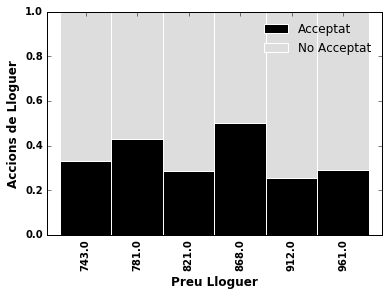

In [38]:
## Binned Both Games

print 'Both'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'BOTH')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index

df_prices_count['price'].iloc[18:20]


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:1])), 
           np.round(np.mean(df_prices_count['price'].iloc[1:4])), 
           np.round(np.mean(df_prices_count['price'].iloc[4:7])), 
           np.round(np.mean(df_prices_count['price'].iloc[7:13])), 
           np.round(np.mean(df_prices_count['price'].iloc[13:18])), 
           np.round(np.mean(df_prices_count['price'].iloc[18:20]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:1])), 
         np.round(np.sum(df_prices_count['1'].iloc[1:4])), 
         np.round(np.sum(df_prices_count['1'].iloc[4:7])), 
         np.round(np.sum(df_prices_count['1'].iloc[7:13])), 
         np.round(np.sum(df_prices_count['1'].iloc[13:18])), 
         np.round(np.sum(df_prices_count['1'].iloc[18:20]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:1])), 
         np.round(np.sum(df_prices_count['0'].iloc[1:4])), 
         np.round(np.sum(df_prices_count['0'].iloc[4:7])), 
         np.round(np.sum(df_prices_count['0'].iloc[7:13])), 
         np.round(np.sum(df_prices_count['0'].iloc[13:18])), 
         np.round(np.sum(df_prices_count['0'].iloc[18:20]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/02_both_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned



None


,1,0,perc_1,perc_0,price
742.888735,1.0,2.0,0.333333,0.666667,742.888735
744.750611,3.0,2.0,0.600000,0.400000,744.750611
746.617154,0.0,1.0,0.000000,1.000000,746.617154
780.033171,1.0,1.0,0.500000,0.500000,780.033171
780.033171,1.0,0.0,1.000000,0.000000,780.033171
781.988142,1.0,5.0,0.166667,0.833333,781.988142
783.948012,2.0,7.0,0.222222,0.777778,783.948012
785.912794,1.0,2.0,0.333333,0.666667,785.912794
787.882500,2.0,4.0,0.333333,0.666667,787.882500
819.034830,1.0,0.0,1.000000,0.000000,819.034830


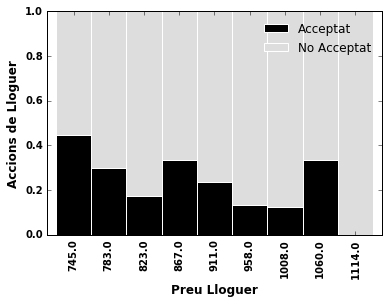

In [39]:
## Binned None Games


print 'None'
df_prices_count = pd.concat([df_prices[(df_prices['selections'] == 1) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts(), df_prices[(df_prices['selections'] == 0) & (df_prices['intervention'] == 'NONE')]['prices'].value_counts()], axis=1)

df_prices_count.columns = ['1','0']

df_prices_count = df_prices_count.fillna(0)
df_prices_count['perc_1'] = df_prices_count['1'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['perc_0'] = df_prices_count['0'] / (df_prices_count['1'] + df_prices_count['0'])
df_prices_count['price'] = df_prices_count.index

df_prices_count['price']


prices_ = [np.round(np.mean(df_prices_count['price'].iloc[0:3])), 
           np.round(np.mean(df_prices_count['price'].iloc[3:9])), 
           np.round(np.mean(df_prices_count['price'].iloc[9:16])), 
           np.round(np.mean(df_prices_count['price'].iloc[16:23])), 
           np.round(np.mean(df_prices_count['price'].iloc[23:29])), 
           np.round(np.mean(df_prices_count['price'].iloc[29:34])), 
           np.round(np.mean(df_prices_count['price'].iloc[34:37])), 
           np.round(np.mean(df_prices_count['price'].iloc[37:39])), 
           np.round(np.mean(df_prices_count['price'].iloc[39]))]

ones_ = [np.round(np.sum(df_prices_count['1'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['1'].iloc[3:9])), 
         np.round(np.sum(df_prices_count['1'].iloc[9:16])), 
         np.round(np.sum(df_prices_count['1'].iloc[16:23])), 
         np.round(np.sum(df_prices_count['1'].iloc[23:29])), 
         np.round(np.sum(df_prices_count['1'].iloc[29:34])), 
         np.round(np.sum(df_prices_count['1'].iloc[34:37])), 
         np.round(np.sum(df_prices_count['1'].iloc[37:39])), 
         np.round(np.sum(df_prices_count['1'].iloc[39]))]

zeros_ = [np.round(np.sum(df_prices_count['0'].iloc[0:3])), 
         np.round(np.sum(df_prices_count['0'].iloc[3:9])), 
         np.round(np.sum(df_prices_count['0'].iloc[9:16])), 
         np.round(np.sum(df_prices_count['0'].iloc[16:23])), 
         np.round(np.sum(df_prices_count['0'].iloc[23:29])), 
         np.round(np.sum(df_prices_count['0'].iloc[29:34])), 
         np.round(np.sum(df_prices_count['0'].iloc[34:37])), 
         np.round(np.sum(df_prices_count['0'].iloc[37:39])), 
         np.round(np.sum(df_prices_count['0'].iloc[39]))]


df_prices_binned=pd.DataFrame()
df_prices_binned['price'] = prices_
df_prices_binned['1'] = ones_
df_prices_binned['0'] = zeros_
df_prices_binned['perc_1'] = df_prices_binned['1'] / (df_prices_binned['1'] + df_prices_binned['0'])
df_prices_binned['perc_0'] = df_prices_binned['0'] / (df_prices_binned['1'] + df_prices_binned['0'])


fig, ax = plt.subplots()
df_prices_binned[['perc_1', 'perc_0']].plot.bar(stacked=True, width=1, position=0.5, edgecolor='white', ax=ax, alpha=1, color=[colors[0], "#dddddd"])
plt.xticks(range(0, len(df_prices_binned['price'])),df_prices_binned['price'], **ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('Preu Lloguer', **axis_font)
plt.ylabel('Accions de Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(['Acceptat', "No Acceptat"], loc='best', fancybox=True, framealpha=0);

plt.savefig('figures/02_none_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

df_prices_binned
df_prices_count


### Evolucio del preu del lloger

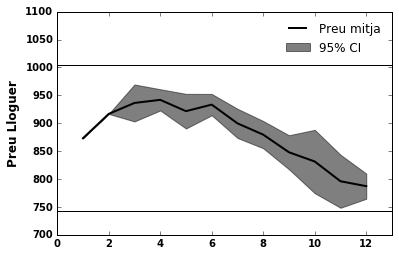

In [40]:
df_games = pd.DataFrame(games)
df_games_treatment = df_games[(df_games['control_intervention'] == 'BOTH') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)
df_prices_rounds

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mitja', linewidth=2)

plt.ylim(700,1100)
plt.hlines(1004, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.hlines(742, 0, 13, colors='black', linewidth=1, linestyles='solid', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/03_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)


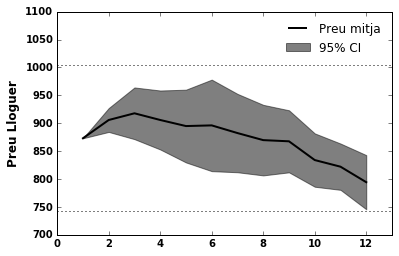

In [41]:
df_games = pd.DataFrame(games)
df_games_no_treatment = df_games[(df_games['control_intervention'] == 'NONE') & (df_games['status'] != 'TEST')]

prices_rounds = []

for i, row in df_games_no_treatment.iterrows():
    rounds = [r['num_round'] for r in df_games_no_treatment['rounds'][i]]
    price = [r['price_init'] for r in df_games_no_treatment['rounds'][i]]
    prices_rounds.append(np.array(price))

    
df_prices_rounds = pd.DataFrame(data=prices_rounds)
df_prices_rounds

price_average = df_prices_rounds.loc[:,:].mean()
price_std = df_prices_rounds.loc[:,:].std()
price_sem = df_prices_rounds.loc[:,:].sem()

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

plt.figure()
error_lower = [price_average[i] -  1.96*(price_sem[i]) for i, e in enumerate(price_average)]
error_higher = [price_average[i] +  1.96*(price_sem[i]) for i, e in enumerate(price_average)]

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(range(1,len(price_average)+1,1), error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(range(1,len(price_average)+1,1), price_average, color="black", zorder=4, label='Preu mitja', linewidth=2)

plt.ylim(700,1100)
plt.hlines(1004, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.hlines(742, 0, 13, colors='black', linewidth=1, linestyles='dotted', label='')
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('Preu Lloguer', **axis_font)
plt.title('', **title_font)
plt.legend(fancybox=True, framealpha=0)
ax = plt.axes()

plt.savefig('figures/03_no_treatment_'+text_dataset+'.png', bbox_inches='tight', dpi=300, transparent=True)

### Estalvis en funcio del mes que es lloga

[1056.79399652 1010.2263254   889.24447223  864.08193017  331.7414747
 1026.61648283 1016.29092925  960.64769344 1017.33393364 1059.488434
 1015.73044116 1101.04338089]
12


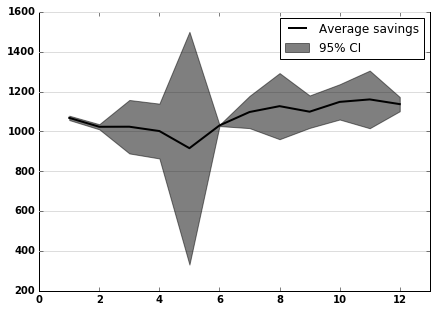

In [42]:
df_round_savings = df_participants_economy[df_participants_economy['house'] == 1][['round_rented','endowment_final']]

#df_round_savings.groupby('round_rented').count()

savings_average = df_round_savings.groupby('round_rented').mean()
savings_std = df_round_savings.groupby('round_rented').std()
savings_sem = df_round_savings.groupby('round_rented').sem()



savings = pd.concat([df_round_savings.groupby('round_rented').count(),
                     savings_average.fillna(0), 
                     savings_sem.fillna(0), 
                     savings_std.fillna(0)], 
                     axis=1, join='inner')
savings.columns = ['n', 'mean', 'std', 'sem']

savings['error_higher'] = savings['mean'] + 1.96*savings['sem']
savings['error_lower'] = savings['mean'] - 1.96*savings['sem']

rounds = savings.index.values
average = savings.iloc[:,1].values
error_lower = savings.iloc[:,5].values
error_higher = savings.iloc[:,4].values

print error_lower
print len(error_lower)

#ax = sns.lineplot(x=range(0, len(price_average)), y=price_average)

fig = plt.figure(figsize=(7,5))

#error_lower = 
#error_higher = 

#for g in games:
#    plt.plot(range(1,13,1), g['round_contributions'], color=color.BLUE, linewidth=.1)

plt.fill_between(rounds, error_lower, error_higher, color="000000", alpha=0.5, zorder=3, label='95% CI')
plt.plot(rounds, average, color="black", zorder=4, label='Average savings', linewidth=2)

plt.ylim()
plt.xlim(0,13)
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)
plt.xlabel('', **axis_font)
plt.ylabel('', **axis_font)
plt.title('', **title_font)
plt.legend()
ax = plt.axes()
ax.yaxis.grid(color='#DDDDDD', linestyle='-', linewidth=1)

plt.savefig('figures/04_'+text_dataset+'.png', bbox_inches='tight', dpi=300)


In [43]:
savings

,n,mean,std,sem,error_higher,error_lower
round_rented,,,,,,
1.0,13,1067.716923,1.545650,5.572922,1078.639850,1056.793997
2.0,9,1023.052222,2.181275,6.543825,1035.878119,1010.226325
3.0,8,1023.403750,24.200239,68.448611,1157.563028,889.244472
4.0,5,1001.622675,31.382700,70.173849,1139.163420,864.081930
5.0,8,915.614167,105.321515,297.894231,1499.486860,331.741475
6.0,2,1029.784573,1.142948,1.616373,1032.952663,1026.616483
7.0,4,1097.161356,20.630211,41.260422,1178.031782,1016.290929
8.0,4,1126.559406,42.324417,84.648833,1292.471119,960.647693
9.0,4,1098.734409,20.765427,41.530855,1180.134885,1017.333934


#### Socio + Polítiques Públiques

In [44]:
df_socio_frame = pd.concat([df_participants_socio, df_participants_frame], axis=1, join='inner')
df_socio_frame.tail()

,socio_pr1,socio_pr2,socio_pr3,socio_pr4,socio_pr5,socio_pr6,socio_pr7,frame_pr1,frame_pr2,frame_pr3,frame_pr4,frame_pr5,frame_pr6
70,M,r4,08013,r4,r4,r3,r2,r3,r3,r3,r8,r7,r3
71,W,r8,08013,r5,r3,r1,r1,r2,r3,r3,r6,r1,r3
72,W,r6,08013,r5,r3,r3,r2,r3,r3,r3,r8,r3,r2
73,M,r4,08012,r4,r4,r3,r2,r2,r3,r2,r7,r4,r1
74,W,r4,08031,r4,r3,r5,r2,r1,r2,r2,r6,r1,r1


Correlacio entre genere i la limitacio de renta


socio_pr1,M,W
frame_pr2,,
r1,0.053333,0.026667
r2,0.026667,0.106667
r3,0.306667,0.480000


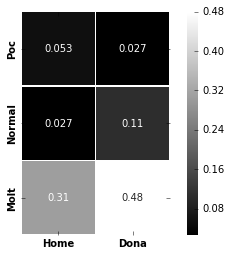

In [45]:
print 'Correlacio entre genere i la limitacio de renta'

df_gender_limit = df_socio_frame[(df_socio_frame['socio_pr1'] == 'M') | (df_socio_frame['socio_pr1'] == 'W')]

cross = pd.crosstab(df_gender_limit.frame_pr2, df_gender_limit.socio_pr1, normalize=True)

xticks_labels = ['Home', 'Dona']
yticks_labels = ['Poc', 'Normal', 'Molt']

plt.clf()
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels, annot=True)

ax.set_ylabel('')    
ax.set_xlabel('')
plt.xticks(**ticks_font)
plt.yticks(**ticks_font)

cross


Correlacio entre tipologia de llar i la limitacio de renta


socio_pr5,r1,r2,r3,r4
frame_pr2,,,,
r1,0.026667,0.000000,0.053333,0.000000
r2,0.000000,0.013333,0.093333,0.026667
r3,0.093333,0.146667,0.440000,0.106667


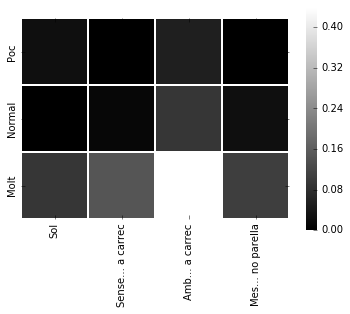

In [46]:
print 'Correlacio entre tipologia de llar i la limitacio de renta'

#|r1|Sol|
#|r2|Llar sense persones a càrrec|
#|r3|Llar amb persones a càrrec|
#|r4|Més persones que no són parella|

cross = pd.crosstab(df_socio_frame.frame_pr2, df_socio_frame.socio_pr5, normalize=True)

xticks_labels = ['Sol', 'Sense... a carrec', 'Amb... a carrec', 'Mes... no parella']
yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, xticklabels=xticks_labels, yticklabels=yticks_labels)

ax.set_ylabel('')    
ax.set_xlabel('')

cross


Correlacio entre regim de tinença i la limitacio de renta


socio_pr6,r1,r2,r3,r4,r5,r6
frame_pr2,,,,,,
r1,0.055556,0.013889,0.000000,0.000000,0.000000,0.013889
r2,0.069444,0.041667,0.013889,0.000000,0.013889,0.000000
r3,0.208333,0.138889,0.250000,0.138889,0.013889,0.027778


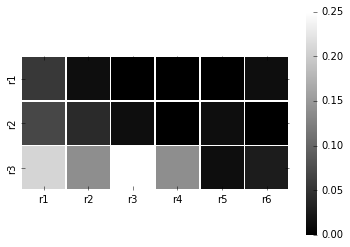

In [47]:
print 'Correlacio entre regim de tinença i la limitacio de renta'

#|r1|En propietat|
#|r2|En propietat pendent de pagament (hipoteca)|
#|r3|En lloguer o relloguer a preu de mercat|
#|r4|En lloguer o relloguer a preu inferior al de mercat|
#|r5|En cessió gratuïta|
#|r6|Habitació de lloguer|
#|r7|Ocupació|
#|r8|Altres|

df_regim_limit = df_socio_frame[(df_socio_frame['socio_pr6'] != 'r8')]

cross = pd.crosstab(df_regim_limit.frame_pr2, df_regim_limit.socio_pr6, normalize=True)

#xticks_labels = ['En propietat', 'Hipoteca', 'Lloguer mercat', 'Lloguer no mercat', 'Cessio', 'Habitacio', 'Ocupacio', 'Altres']
#yticks_labels = ['Poc', 'Normal', 'Molt']
ax = sns.heatmap(cross, cmap='gray',square=True, linewidths=.5, 
                 #xticklabels=xticks_labels, yticklabels=yticks_labels
                )

ax.set_ylabel('')    
ax.set_xlabel('')

cross
